## Single Input Graphs

In [1]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph

In [2]:
# We now create an AgentState - shared data structure that keeps track of information as your application runs. 

class AgentState(TypedDict): # Our state schema
    name : str 


def compliment_node(state: AgentState) -> AgentState:
    """Simple node that compliments the user"""

    state['name'] = state["name"] + " you're doing an amazing job learning LangGraph!"

    return state 

In [3]:
graph = StateGraph(AgentState)

graph.add_node("compliment", compliment_node)

graph.set_entry_point("compliment")
graph.set_finish_point("compliment")

app = graph.compile()

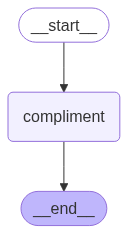

In [4]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [6]:
result = app.invoke({"name": "Bob"})
print(result)
result["name"]

{'name': "Bob you're doing an amazing job learning LangGraph!"}


"Bob you're doing an amazing job learning LangGraph!"

## Multiple Input Graphs

In [7]:
from typing import TypedDict, List
from langgraph.graph import StateGraph 
import math

In [8]:
class AgentState(TypedDict):
    name: str 
    values: List[int]
    operation: str
    result: str 

In [9]:
def process_values(state: AgentState) -> AgentState:
    """This function handles multiple different inputs"""
    if state["operation"] == "+":
        state["result"] = f"Hi {state['name']}, your answer is: {sum(state['values'])}"
    elif state["operation"] == "*":
        state["result"] = f"Hi {state['name']}, your answer is: {math.prod(state['values'])}"
    else:
        state["result"] = "Invalid!"

    return state

In [10]:
graph = StateGraph(AgentState)

graph.add_node("processor", process_values)
graph.set_entry_point("processor") 
graph.set_finish_point("processor") 

app = graph.compile() 

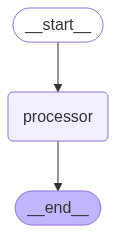

In [11]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
answers = app.invoke({"name": "Jack Sparrow","values": [1,2,3,4] , "operation": "*"})
print(answers)
answers["result"]

{'name': 'Jack Sparrow', 'values': [1, 2, 3, 4], 'operation': '*', 'result': 'Hi Jack Sparrow, your answer is: 24'}


'Hi Jack Sparrow, your answer is: 24'

## Sequential Graph

In [13]:
from typing import TypedDict 
from langgraph.graph import StateGraph

In [14]:
class AgentState(TypedDict):
    name: str
    age: str
    skills : list
    final_result: str

In [15]:
def first_node(state:AgentState) -> AgentState:
    """This node will greet the user"""

    state["final_result"] = f"{state["name"]} welcome to the system!"
    return state

def second_node(state:AgentState) -> AgentState:
    """This node will describe the user's age"""

    state["final_result"] = state["final_result"] + f" You are {state["age"]} years old!"
    return state


def third_node(state:AgentState) -> AgentState:
    """This node will list the user's skills in a formatted string"""
    state["final_result"] = state["final_result"] + f" You have skills in: {", ".join(state["skills"])}"

    return state

In [16]:
graph = StateGraph(AgentState)

graph.add_node("personalize", first_node)
graph.add_node("age_description", second_node)
graph.add_node("skills_description", third_node)

graph.set_entry_point("personalize")
graph.add_edge("personalize", "age_description")
graph.add_edge("age_description", "skills_description")
graph.set_finish_point("skills_description")
app = graph.compile()

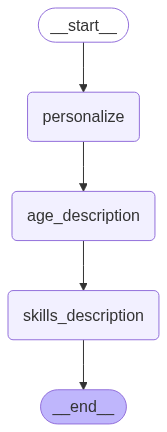

In [17]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [18]:
result = app.invoke({"name": "Linda", "age": 31, "skills":["Python", "Machine Learning", "LangGraph"]})
print(result)
result["final_result"]

{'name': 'Linda', 'age': 31, 'skills': ['Python', 'Machine Learning', 'LangGraph'], 'final_result': 'Linda welcome to the system! You are 31 years old! You have skills in: Python, Machine Learning, LangGraph'}


'Linda welcome to the system! You are 31 years old! You have skills in: Python, Machine Learning, LangGraph'

## Conditional Graph

In [19]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

In [20]:
class AgentState(TypedDict):
    number1: int 
    operation: str
    number2: int
    finalNumber: int
    number3: int
    operation2: str
    number4: int
    finalNumber2: int

In [21]:
def adder(state:AgentState) -> AgentState:
    """This node adds the 2 numbers"""
    print("adder")
    state["finalNumber"] = state["number1"] + state["number2"]
    return state

def subtractor(state:AgentState) -> AgentState:
    """This node subtracts the 2 numbers"""
    print("subtractor")
    state["finalNumber"] = state["number1"] - state["number2"]
    return state

def decide_next_node(state:AgentState) -> AgentState:
    """This node will select the next phase"""
    if state["operation"] == "+":
        return "addition_operation"
    
    elif state["operation"] == "-":
        print("SUB 1")
        return "subtraction_operation"   


def adder2(state:AgentState) -> AgentState:
    """This node adds the 2 numbers"""
    print("adder1")
    state["finalNumber2"] = state["number3"] + state["number4"]
    print(state["finalNumber2"])

    return state

def subtractor2(state:AgentState) -> AgentState:
    """This node subtracts the 2 numbers"""
    print("subtractor1")
    state["finalNumber2"] = state["number3"] - state["number4"]
    print(state["finalNumber2"])
    return state

def decide_next_node1(state:AgentState) -> AgentState:
    """This node will select the next phase"""
    if state["operation2"] == "+":
        print("ADD1")
        return "addition_operation2"
    
    elif state["operation2"] == "-":
        return "subtraction_operation2"   

In [22]:
graph = StateGraph(AgentState)

graph.add_node("add_node", adder)
graph.add_node("subtract_node", subtractor)
graph.add_node("router", lambda state:state) 

graph.add_node("add_node2", adder2)
graph.add_node("subtract_node2", subtractor2)
graph.add_node("router2", lambda state:state) 


graph.add_edge(START, "router")

graph.add_conditional_edges(
    "router", 
    decide_next_node,
    {
        # Edge: Node format
        "addition_operation": "add_node",
        "subtraction_operation": "subtract_node"
    }
)


graph.add_edge("add_node", "router2")
graph.add_edge("subtract_node", "router2")

graph.add_conditional_edges(
    "router2", 
    decide_next_node1,
    {
        # Edge: Node format
        "addition_operation2": "add_node2",
        "subtraction_operation2": "subtract_node2"
    }
)


graph.add_edge("add_node2", END)
graph.add_edge("subtract_node2", END)

app = graph.compile()

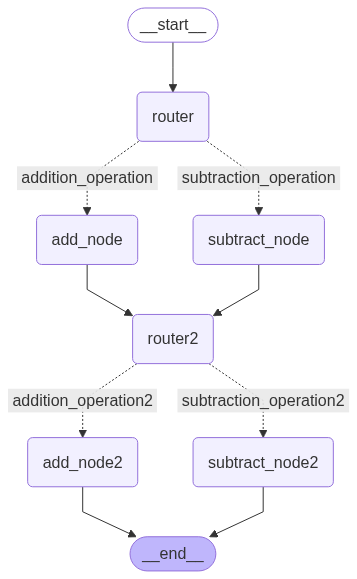

In [23]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [24]:
initial_state = AgentState(number1 = 10, operation="-", number2 = 5, number3 = 7, number4=2, operation2="+", finalNumber= 0, finalNumber2 = 0)
result = app.invoke(initial_state)
print(result)
print(f"Final Result: {result['finalNumber']} and {result['finalNumber2']}")

SUB 1
subtractor
ADD1
adder1
9
{'number1': 10, 'operation': '-', 'number2': 5, 'finalNumber': 5, 'number3': 7, 'operation2': '+', 'number4': 2, 'finalNumber2': 9}
Final Result: 5 and 9


##  Looping Graph

In [25]:
from langgraph.graph import StateGraph, END
import random
from typing import Dict, List, TypedDict

In [26]:
class GameState(TypedDict):
    player_name: str
    target_number: int
    guesses: List[int]
    attempts: int
    hint: str
    lower_bound: int 
    upper_bound: int 

In [27]:
def setup_node(state: GameState) -> GameState:
    """Initialize the game with a random target number"""
    state["player_name"] = f"Welcome, {state['player_name']}!"
    state["target_number"] = random.randint(1, 20)
    state["guesses"] = []
    state["attempts"] = 0
    state["hint"] = "Game started! Try to guess the number."
    state["lower_bound"] = 1 
    state["upper_bound"] = 20 
    print(f"{state['player_name']} The game has begun. I'm thinking of a number between 1 and 20.")
    return state

In [28]:
def guess_node(state: GameState) -> GameState:
    """Generate a smarter guess based on previous hints"""
    
    possible_guesses = [i for i in range(state["lower_bound"], state["upper_bound"] + 1) if i not in state["guesses"]]
    if possible_guesses:
        guess = random.choice(possible_guesses)
    else:
        
        guess = random.randint(state["lower_bound"], state["upper_bound"])
    
    state["guesses"].append(guess)
    state["attempts"] += 1
    print(f"Attempt {state['attempts']}: Guessing {guess} (Current range: {state['lower_bound']}-{state['upper_bound']})")
    return state

In [30]:
def hint_node(state: GameState) -> GameState:
    """Here we provide a hint based on the last guess and update the bounds"""
    latest_guess = state["guesses"][-1]
    target = state["target_number"]
    
    if latest_guess < target:
        state["hint"] = f"The number {latest_guess} is too low. Try higher!"
        
        state["lower_bound"] = max(state["lower_bound"], latest_guess + 1)
        print(f"Hint: {state['hint']}")
        
    elif latest_guess > target:
        state["hint"] = f"The number {latest_guess} is too high. Try lower!"
      
        state["upper_bound"] = min(state["upper_bound"], latest_guess - 1)
        print(f"Hint: {state['hint']}")
    else:
        state["hint"] = f"Correct! You found the number {target} in {state['attempts']} attempts."
        print(f"Success! {state['hint']}")
    
    return state

In [29]:
def should_continue(state: GameState) -> str:
    """Determine if we should continue guessing or end the game"""
    
    # There are 2 end conditions - either 7 is reached or the correct number is guessed
    
    latest_guess = state["guesses"][-1]
    if latest_guess == state["target_number"]:
        print(f"GAME OVER: Number found!")
        return "end"
    elif state["attempts"] >= 7:
        print(f"GAME OVER: Maximum attempts reached! The number was {state['target_number']}")
        return "end"
    else:
        print(f"CONTINUING: {state['attempts']}/7 attempts used")
        return "continue"

In [31]:
graph = StateGraph(GameState)
graph.add_node("setup", setup_node)
graph.add_node("guess", guess_node)
graph.add_node("hint_node", hint_node)  


graph.add_edge("setup", "guess")
graph.add_edge("guess", "hint_node")  


graph.add_conditional_edges(
    "hint_node", 
    should_continue,
    {
        "continue": "guess",
        "end": END
    }
)

graph.set_entry_point("setup")
app = graph.compile()

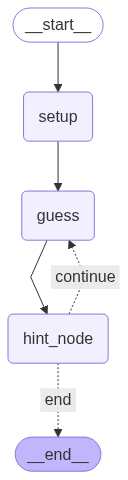

In [33]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [34]:
result = app.invoke({"player_name": "Student", "guesses": [], "attempts": 0, "lower_bound": 1, "upper_bound": 20})
print(result)
print(f"Final Result: {result['hint']}")

Welcome, Student! The game has begun. I'm thinking of a number between 1 and 20.
Attempt 1: Guessing 18 (Current range: 1-20)
Hint: The number 18 is too high. Try lower!
CONTINUING: 1/7 attempts used
Attempt 2: Guessing 11 (Current range: 1-17)
Hint: The number 11 is too high. Try lower!
CONTINUING: 2/7 attempts used
Attempt 3: Guessing 9 (Current range: 1-10)
Hint: The number 9 is too low. Try higher!
CONTINUING: 3/7 attempts used
Attempt 4: Guessing 10 (Current range: 10-10)
Success! Correct! You found the number 10 in 4 attempts.
GAME OVER: Number found!
{'player_name': 'Welcome, Student!', 'target_number': 10, 'guesses': [18, 11, 9, 10], 'attempts': 4, 'hint': 'Correct! You found the number 10 in 4 attempts.', 'lower_bound': 10, 'upper_bound': 10}
Final Result: Correct! You found the number 10 in 4 attempts.
